# Introduction

Logistic Regression is a confusing term. It has "Regression" in it, but is used for Classification really. We'll understand Logistic Regression with an example

In [2]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [249]:
X, y = make_blobs(n_samples=100, n_features=1, centers=2, random_state=21)

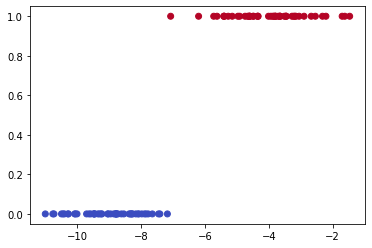

In [68]:
plt.scatter(X.ravel(), y, c=y, cmap=plt.cm.coolwarm)

What we'd like to do is, fit a S-shaped curve to the datapoints above, like this:

In [101]:
def f(x, scale):
    return scale * x

def sigmoid(x, scale):
    return 1 / (1 + np.exp(-f(x, scale)))

In [116]:
from sklearn.preprocessing import MinMaxScaler

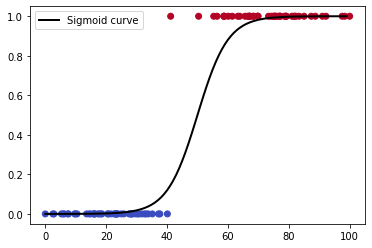

In [130]:
plt.scatter(MinMaxScaler(feature_range=(0, 100)).fit_transform(X).ravel(), y, c=y, cmap=plt.cm.coolwarm)
plt.plot(sigmoid(np.arange(-10, 10, 0.2), 1), label='Sigmoid curve', linewidth=2.0, color='k');
plt.legend();

**Note**: I've scaled the input features for illustration purposes, the actual method doesn't do that

The sigmoid function is of the following form for a given x:

$$ sigmoid(x) = {\frac{1}{1 + e^{-f(x)}}} $$ 

The function f(x) is a function which "scales" the input features using their linear combinations. More on this later.

This is only one of the Sigmoid curve that we can fit to the dataset. There are several others, like this:

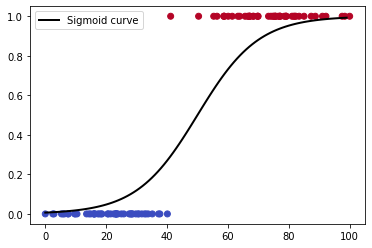

In [133]:
plt.scatter(MinMaxScaler(feature_range=(0, 100)).fit_transform(X).ravel(), y, c=y, cmap=plt.cm.coolwarm)
plt.plot(sigmoid(np.arange(-10, 10, 0.2), 0.5), label='Sigmoid curve', linewidth=2.0, color='k');
plt.legend();

or this:

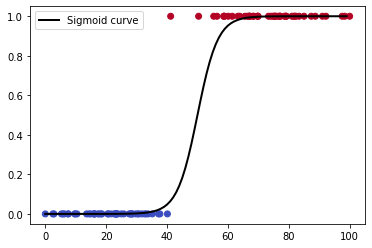

In [134]:
plt.scatter(MinMaxScaler(feature_range=(0, 100)).fit_transform(X).ravel(), y, c=y, cmap=plt.cm.coolwarm)
plt.plot(sigmoid(np.arange(-10, 10, 0.2), 1.5), label='Sigmoid curve', linewidth=2.0, color='k');
plt.legend();

You can see that they differ with respect to smoothness or abruptness. We can also fit this curve which looks like a step function to the dataset:

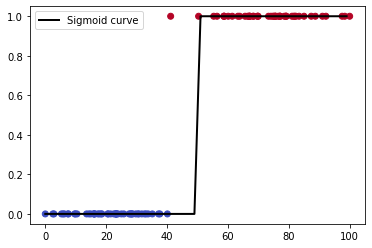

In [139]:
plt.scatter(MinMaxScaler(feature_range=(0, 100)).fit_transform(X).ravel(), y, c=y, cmap=plt.cm.coolwarm)
plt.plot(sigmoid(np.arange(-10, 10, 0.2), 60), label='Sigmoid curve', linewidth=2.0, color='k');
plt.legend();

But what does that sigmoid function represent? And which one of those should we use for the dataset? <br>
The sigmoid function represents the probability for a given feature to belong to the class represented by `y=1`

Again, we'll go with an example

In [165]:
X_scaled = MinMaxScaler(feature_range=(0, 100)).fit_transform(X).ravel()

In [230]:
pd.DataFrame([X_scaled, y.astype('str')], index=None).T.groupby(1).agg(['min', np.argmin])

0       
        min argmin
1                 
0   0.00000     31
1  41.18821     44

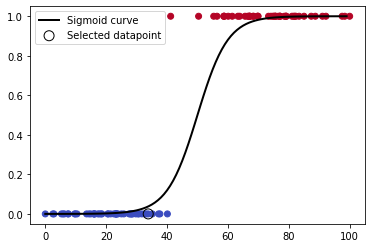

In [235]:
idx = 45
plt.scatter(X_scaled, y, c=y, cmap=plt.cm.coolwarm)
plt.plot(sigmoid(np.arange(-10, 10, 0.2), 1), label='Sigmoid curve', linewidth=2.0, color='k');
plt.scatter(X_scaled[idx], y[idx], facecolors='none', edgecolors='k', s=100, linewidth=1, label='Selected datapoint')
plt.legend();

What is the probability of the selected point to be of the class `1`? It is given by the Sigmoid curve! Find sigmoid curve's value at x = selected point and there you have it, the probability. If we consider the sigmoid plotted above, we'd get the probability of around 0.1, which would be a great estimate

## How do we choose the correct sigmoid?

This part is a little tricky. What we need to do is change the Y-axis to $y = log(\frac{p}{(1-p)})$. This function is called the Logit function. Lets do that.
Implementation note: since our red points are at p = 1(100% probability that they are red, or belong to class 1), if we convert these to the new Y-axis coordinates, we get $y = \infty$. The same is the case with class 0, we'll get $y=-\infty$. We cannot plot points at infinity, so we're instead going to convert these probabilities to something really close to 1 and 0 respectively

In [250]:
orig_y = y.copy()

In [312]:
y = orig_y.copy()

In [313]:
y = y.astype('float')

In [314]:
y[y == 1] = 0.9999
y[y == 0] = 0.0001

In [315]:
def logit(p):
    return p/(1 - p)

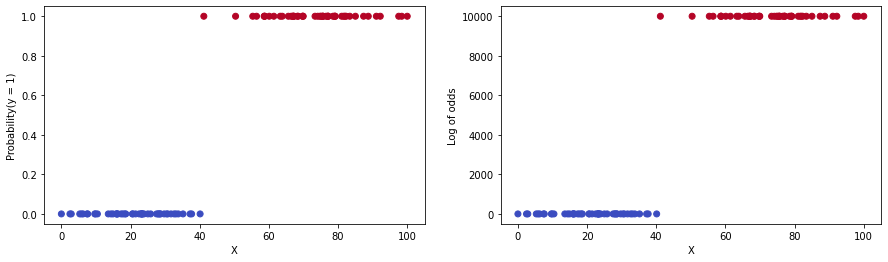

In [376]:
plt.rcParams['figure.figsize'] = 15, 4
plt.subplot(1, 2, 1)
plt.scatter(X_scaled, orig_y, c=y, cmap=plt.cm.coolwarm)
plt.ylabel('Probability(y = 1)');
plt.xlabel('X')

plt.subplot(1, 2, 2)
plt.scatter(X_scaled, logit(y), c=y, cmap=plt.cm.coolwarm)
plt.ylabel('Log of odds')
plt.xlabel('X');

It is in this domain that a line is fixed on these datapoints. In theory, the sigmoid curve gets converted into a straight line in this domain, but again, since we cannot plot infinity, we're going to simulate a line for illustration

In [330]:
def generate_line(x, m, c):
    return m * x + c

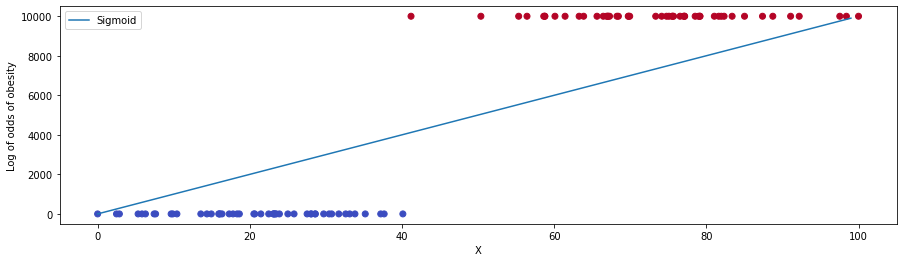

In [345]:
plt.scatter(X_scaled, logit(y), c=y, cmap=plt.cm.coolwarm)
plt.plot(generate_line(np.arange(0, 100), 100, 1), label='Sigmoid')
plt.ylabel('Log of odds of obesity')
plt.xlabel('X');
plt.legend();

The line has been generated sloppily and doesn't exactly represent the sigmoid curve in the new Y-axis. Again, view this only for intuition purposes. It is in this log odds domain that we fit a straight line to this dataset. Yes, a straight line. And the coefficients that the model gives us signifies the coefficients in this domain. If the line shown above is the line fitted to the dataset, then to find the log odds of obesity for a datapoint x, we need to find the value of line at that point x. And of course, inversely, the line can be converted to the original domain as follows:

Say for now f(x) = x<br>
$f(x) = log(p/(1-p))$<br>
$x = log(p/(1-p))$<br>
$p/(1-p) = e^x$<br>
$(1-p)/p = e^{-x}$<br>
$1/p - 1 = e^{-x}$<br>
$1/p = 1 + e^{-x}$<br>
$p = 1/(1 + e^{-x})$

## But how is this different from Linear Regression then?

Linear Regression fits a line to the dataset for regression minimizing the squared differences between the datapoints and the fitted line. In this case, if we apply the same logic, we'd end up getting an infinite squared difference each time since the datapoints are moved to $y = \infty$. That's why Logistic Regression uses Maximum Likelihood for fitting the line.

## Hmm, okay, but how does that work?

First we project the datapoints in the new Y-axis graphs to the fitted line. For example, take this point:

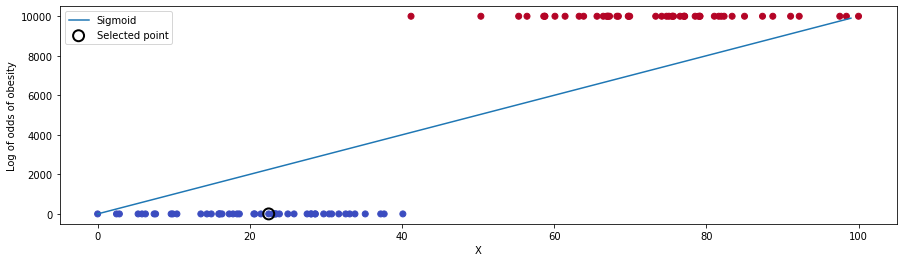

In [361]:
idx = 14
plt.scatter(X_scaled, logit(y), c=y, cmap=plt.cm.coolwarm)
plt.plot(generate_line(np.arange(0, 100), 100, 1), label='Sigmoid')
plt.scatter(X_scaled[idx], logit(y)[idx], cmap=plt.cm.coolwarm, s=120, linewidth=2.0, facecolors='none', edgecolors='k', label='Selected point')
plt.ylabel('Log of odds of obesity')
plt.xlabel('X');
plt.legend();

Project it onto the line

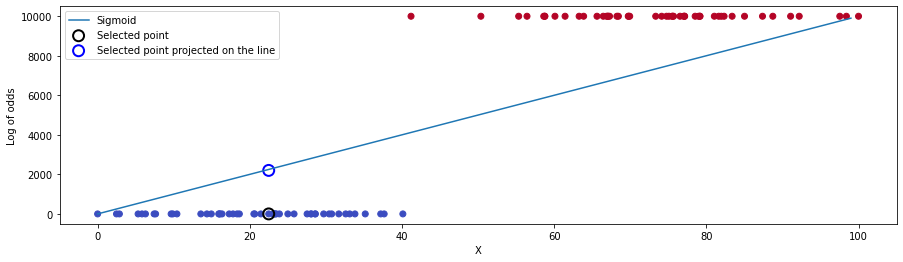

In [375]:
idx = 14
plt.scatter(X_scaled, logit(y), c=y, cmap=plt.cm.coolwarm)
plt.plot(generate_line(np.arange(0, 100), 100, 1), label='Sigmoid')
plt.scatter(X_scaled[idx], logit(y)[idx], cmap=plt.cm.coolwarm, s=120, linewidth=2.0, facecolors='none', edgecolors='k', label='Selected point')
plt.scatter(X_scaled[idx], generate_line(np.arange(0, 100), 100, 1)[idx] + 800, cmap=plt.cm.coolwarm, s=120, linewidth=2.0, facecolors='none', edgecolors='blue', label='Selected point projected on the line')
plt.ylabel('Log of odds')
plt.xlabel('X');
plt.legend();

Do the same for all the other points. Now take this projected value(call it x) and feed it into the sigmoid formula(call this result p) for all the other points. You'll get a sigmoid curve back. Multiply the sigmoid value for all the datapoints together to get the likelihood of **all** the datapoints being modelled well by this line.

**Note**: For `y=0` take (1-p)

To summarize:

1. Take the projection of the points at the scale of log of odds, call it x
2. Feed result of point 1 to the sigmoid function, call it p
3. Repeat point 1 and 2 for all the points
4. Multiply all the values obtained in point 2 to get the likelihood given the selected sigmoid function
5. Rotate the line in the log of odds domain such that the likelihood increases
6. Repeat this process until the optimal line is reached

# References

- Intro to Logistic Regression by StatQuest - https://www.youtube.com/watch?v=yIYKR4sgzI8
- Logistic Regression Part 2 by StatQuest - https://www.youtube.com/watch?v=vN5cNN2-HWE
- Logistic Regression Part 3 by StatQuest - https://www.youtube.com/watch?v=BfKanl1aSG0&lc=Ugy8W1qwq9g0iGaO2Nh4AaABAg.8xy2uh73R-58xy80KIG-bB
- https://www.latex4technics.com/?note=gw021j